<a href="https://colab.research.google.com/github/shahafp/Conala-Challenge/blob/master/conala_tokenized_normal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import json
import re
import torch
import numpy
from torch import autograd, nn, optim
import torch.nn.functional as F
import re
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline
import collections
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu
from google.colab import drive

In [0]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [0]:
SOS_token = 0
EOS_token = 1
UNK_token = 2
MAX_LENGTH = 100

In [0]:
class VocabIntent :
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 2: "UNK"}
        self.n_words = 3  # Count SOS and EOS and UNK

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


In [0]:
class VocabCode:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 2: "UNK"}
        self.n_words = 3  # Count SOS and EOS and UNK

    def addSentence(self, sentence):
        for word in re.split('([^a-zA-Z0-9 ])',sentence):
          if word is not '':
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [0]:
def orginize_data(data_type):
  json_data = '/content/drive/My Drive/conala/' + data_type  
  path = open(json_data, "r")
  data = json.load(path)
  pairs=[]
  for dic in data:
      if dic["rewritten_intent"] is None:
          continue
      pairs.append([dic["rewritten_intent"], dic["snippet"]])
  return pairs

In [0]:
def prepare_data(vocab1_name, vocab2_name, data_type):
  pairs=orginize_data(data_type=data_type)
  intent_vocab=VocabIntent(vocab1_name)
  code_vocab=VocabCode(vocab2_name)

  for pair in pairs:
    intent_vocab.addSentence(pair[0])
    code_vocab.addSentence(pair[1])
  
  return intent_vocab, code_vocab, pairs

In [0]:
input_lang, output_lang, pairs= prepare_data('intent', 'code', 'conala-train.json')
test_pairs=orginize_data('conala-test.json')

In [0]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] if word in lang.word2index else UNK_token for word in sentence.split(' ')]

def c_indexesFromSentence(lang, sentence):
    sen = re.split('([^a-zA-Z0-9 ])',sentence)
    return [lang.word2index[word] for word in sen if word is not '']

def tensorFromSentence(lang, sentence, key):
    if key is 'intent':
      indexes = indexesFromSentence(lang, sentence)
      indexes.append(EOS_token)
    else:
      indexes = c_indexesFromSentence(lang, sentence)
      indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0], 'intent')
    target_tensor =tensorFromSentence(output_lang, pair[1], 'code')
    return (input_tensor, target_tensor)


In [0]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [0]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [0]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    return plot_losses

In [0]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [0]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence, 'intent')
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [0]:
def evaluateRandomly(encoder, decoder, pairs, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ''.join(output_words)
        output_sentence = output_sentence.strip('<EOS>')
        print('<', output_sentence)
        print('')

In [0]:
def evaluate_data_set(encoder, decoder, pairs, n=10):
  answer_list=[]
  for i, pair in enumerate(pairs,0):
      output_words, attentions = evaluate(encoder, decoder, pair[0])
      output_sentence = ''.join(output_words)
      answer_list.append(output_sentence.strip('<EOS>'))
      if i%20==0:
        print('>', pair[0])
        print('=', pair[1])
        print('<', output_sentence)
        print('')
  return answer_list

In [0]:
hidden_size = 300
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.3).to(device)

train_losses=trainIters(encoder1, attn_decoder1, 75000, print_every=100)

0m 14s (- 177m 14s) (100 0%) 5.8833
0m 19s (- 120m 58s) (200 0%) 4.4249
0m 23s (- 99m 34s) (300 0%) 4.0122
0m 29s (- 91m 1s) (400 0%) 3.9572
0m 34s (- 85m 31s) (500 0%) 4.0142
0m 39s (- 81m 40s) (600 0%) 3.7121
0m 45s (- 79m 49s) (700 0%) 3.9077
0m 50s (- 78m 24s) (800 1%) 3.9659
0m 56s (- 76m 55s) (900 1%) 3.6768
1m 1s (- 75m 23s) (1000 1%) 3.7950
1m 6s (- 74m 37s) (1100 1%) 3.6522
1m 11s (- 72m 57s) (1200 1%) 3.3156
1m 16s (- 71m 59s) (1300 1%) 3.5739
1m 21s (- 71m 5s) (1400 1%) 3.6699
1m 26s (- 70m 28s) (1500 2%) 3.5587
1m 31s (- 70m 3s) (1600 2%) 3.5780
1m 36s (- 69m 25s) (1700 2%) 3.5421
1m 41s (- 68m 54s) (1800 2%) 3.6031
1m 46s (- 68m 9s) (1900 2%) 3.3772
1m 51s (- 67m 38s) (2000 2%) 3.4636
1m 56s (- 67m 24s) (2100 2%) 3.4545
2m 1s (- 66m 52s) (2200 2%) 3.1964
2m 6s (- 66m 24s) (2300 3%) 3.4571
2m 11s (- 66m 14s) (2400 3%) 3.6411
2m 16s (- 65m 59s) (2500 3%) 3.2390
2m 21s (- 65m 41s) (2600 3%) 3.2780
2m 26s (- 65m 34s) (2700 3%) 3.3851
2m 32s (- 65m 23s) (2800 3%) 3.2238
2m 37s 

<Figure size 432x288 with 0 Axes>

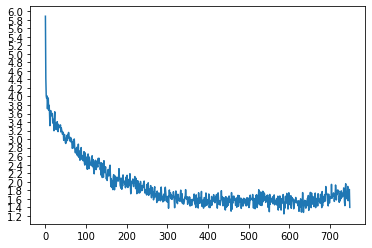

In [0]:
showPlot(train_losses)

In [0]:
evaluateRandomly(encoder1, attn_decoder1, pairs)

> print two numbers `10` and `20` using string formatting
= """{0} {1}""".format(10, 20)
< """{0{}"".join(())

> output first 100 characters in a string `my_string`
= print(my_string[0:100])
< print(my_string.string()string)string:100[:100])

> concatenate dataframe `df1` with `df2` whilst removing duplicates
= pandas.concat([df1, df2]).drop_duplicates().reset_index(drop=True)
< pandas.concat([df1[reset')]drop)

> Sort dictionary `dict1` by value in ascending order
= sorted(dict1, key=dict1.get)
< sorted(dict1( key=dict1(d.get))

> printing numbers rounding up to third decimal place
= print('%.3f' % 3.1415)
< print('%join'.joinjoinjoinjoinjoinjoinjoinjoinjoinjoin('3f'

> Get the zip output as list from the lists `[1, 2, 3]`, `[4, 5, 6]`, `[7, 8, 9]`
= [list(a) for a in zip([1, 2, 3], [4, 5, 6], [7, 8, 9])]
< [(a[0]((((((])(,,,,])(,,

> get the ASCII value of a character as an int
= ord()
< ord()(u3042(u3042()

> sort list `['14:10:01', '03:12:08']`
= sorted(['14:10:01', '03:12:08'])
< 

In [0]:
train_answers=evaluate_data_set(encoder1, attn_decoder1, pairs)
acc=0
for i in range(len(train_answers)):
  if pairs[i][1]==train_answers[i]:
    acc+=1
print("Correct on {} snippets out of {} on training set".format(acc, len(pairs)))

> Concatenate elements of a list 'x' of multiple integers to a single integer
= sum(d * 10 ** i for i, d in enumerate(x[::-1]))
< sum(d , 10 ) 10 * 10 * 10 * 10 ,(x[1]),),))<EOS>

> convert list `l` to dictionary having each two adjacent elements as key/value pair
= dict(zip(l[::2], l[1::2]))
< dict(zip(l:::::::::::::::<EOS>

> replace white spaces in dataframe `df` with '_'
= df.replace(' ', '_', regex=True)
< df.replace(', ', ')=', ')<EOS>

> Return a subplot axes positioned by the grid definition `1,1,1` using matpotlib
= fig.add_subplot(1, 1, 1)
< datetime.add_subplot(', 1/ 1.1,', ')<EOS>

> match the pattern '[:;][)(](?![)(])' to the string `str`
= re.match('[:;][)(](?![)(])', str)
< re.match('[(]((]((( str(,, str(,, s)<EOS>

> trim whitespace in string `s`
= s.strip()
< s[strip()<EOS>

> Get the first and last 3 elements of list `l`
= l[:3] + l[-3:]
< l[: + l[+]<EOS>

> format a string `num` using string formatting
= """{0:.3g}""".format(num)
< """{0:3g<.}"(".()<EOS>

> regular e

In [0]:
#test set eval
snippets=[w[1] for w in test_pairs]
answers=evaluate_data_set(encoder1, attn_decoder1, test_pairs)

> send a signal `signal.SIGUSR1` to the current process
= os.kill(os.getpid(), signal.SIGUSR1)
< your.communicate()<EOS>

> convert a string `123,456.908` with dot and comma into a floating number
= float('123,456.908'.replace(',', ''))
< p ('(,, struct.csv',<EOS>

> sum all elements of nested list `L`
= sum(sum(i) if isinstance(i, list) else i for i in L)
< print(sum(,,)),))<EOS>

> Insert a 'None' value into a SQLite3 table.
= db.execute("INSERT INTO present VALUES('test2', ?, 10)", (None,))
< ((((()())(<EOS>

> format string "({0.goals} goals, ${0.penalties})"
= """({0.goals} goals, ${0.penalties})""".format(self)
< {{s.'}()(://<EOS>

> create list `lst` containing 100 instances of object `Object`
= lst = [Object() for i in range(100)]
< ((((1,10)((10))<EOS>

> count the occurrences of item "b" in list `l`
= l.count('b')
< sum(l)<EOS>

> change working directory to the directory `owd`
= os.chdir(owd)
< os.path.realpath('(path/\\))\)\)\)()()()()())())<EOS>

> extract all the values w

In [0]:
c_snippets=[[c for c in s] for s in snippets]
c_answers=[[c for c in s] for s in answers]

In [0]:
blue_nltk=sentence_bleu
cc=SmoothingFunction()
score=0
acc=0
for i in range(len(c_answers)):
  score+=blue_nltk([c_snippets[i]], c_answers[i],smoothing_function=cc.method4)
  if c_snippets[i]==c_answers[i]:
    acc+=1
 
print("Avg Bleu scroe is: {}".format(score/len(c_answers)))
print("Correct on {} snippets out of {} on test set".format(acc, len(c_answers)))

Avg Bleu scroe is: 0.12650858422796452
Correct on 0 snippets out of 477 on test set


In [0]:
ls = [["check if item from list `b` is in list `a`","print(x in a for x in b)"]]
n_lang = evaluate_data_set(encoder1,attn_decoder1, ls)

> check if item from list `b` is in list `a`
= print(x in a for x in b)
< any(any(x in a for x in b) for x in a(<EOS>



In [0]:
ls = [["create a matrix from a list `[4, 5, 6]","x = scipy.matrix([4, 5, 6]).transpose()"]]
n_lang = evaluate_data_set(encoder1,attn_decoder1, ls)

> create a matrix from a list `[4, 5, 6]
= x = scipy.matrix([4, 5, 6]).transpose()
< [(x.max(x.max(),,])<EOS>

